# Bramblemet water level example
The goal of this notebook is to compare different multi-output Gaussian process models, such as the MOSM, CSM, SM-LMC, and the CONV. The dataset consists of four weather stations in south England, each registering since April 2012 for every 5 minutes the following statistics:

 - WSPD: wind speed in knots
 - WD: wind direction in degrees
 - GST: maximum gust in knots
 - ATMP: air temperature in degrees Celsius
 - WTMP: water temperature in degrees Celsius
 - BARO: barometric pressure in millibars
 - DEPTH: water depth in metres
 - VIS: visibility

The four stations have the following locations:
![Bramblemet](https://www.bramblemet.co.uk/images/map.gif)

We replicate a similar experiment by Álvarez and Lawrence (http://papers.nips.cc/paper/3553-sparse-convolved-gaussian-processes-for-multi-output-regression), in which we train a multi-output Gaussian process on the Tidal Height data of the four sensors.

In [1]:
import numpy as np
import pandas as pd
import mogptk

We will load the four data series and combine their date and time fields. Additionally, we select a single week in June 2020.

In [2]:
start_date = '2020-06-01'
end_date = '2020-06-08'

print('Loading Bramble')
bramblemet = pd.read_csv('data/bramblemet/bramblemet.csv.gz', compression='gzip', low_memory=False)
bramblemet['Date'] = pd.to_datetime(bramblemet['Date'] + ' ' + bramblemet['Time'], format='%d/%m/%Y %H:%M')
bramblemet = bramblemet.drop(columns=['Time'])
bramblemet = bramblemet.loc[(bramblemet['Date'] >= start_date) & (bramblemet['Date'] < end_date)]

print('Loading Camber')
cambermet = pd.read_csv('data/bramblemet/cambermet.csv.gz', compression='gzip', low_memory=False)
cambermet['Date'] = pd.to_datetime(cambermet['Date'] + ' ' + cambermet['Time'], format='%d/%m/%Y %H:%M')
cambermet = cambermet.drop(columns=['Time'])
cambermet = cambermet.loc[(cambermet['Date'] >= start_date) & (cambermet['Date'] < end_date)]

print('Loading Chi')
chimet = pd.read_csv('data/bramblemet/chimet.csv.gz', compression='gzip', low_memory=False)
chimet['Date'] = pd.to_datetime(chimet['Date'] + ' ' + chimet['Time'], format='%d/%m/%Y %H:%M')
chimet = chimet.drop(columns=['Time'])
chimet = chimet.loc[(chimet['Date'] >= start_date) & (chimet['Date'] < end_date)]

print('Loading Soton')
sotonmet = pd.read_csv('data/bramblemet/sotonmet.csv.gz', compression='gzip', low_memory=False)
sotonmet['Date'] = pd.to_datetime(sotonmet['Date'] + ' ' + sotonmet['Time'], format='%d/%m/%Y %H:%M')
sotonmet = sotonmet.drop(columns=['Time'])
sotonmet = sotonmet.loc[(sotonmet['Date'] >= start_date) & (sotonmet['Date'] < end_date)]

bramblemet.head(5)

Loading Bramble
Loading Camber
Loading Chi
Loading Soton


,Date,WSPD,WD,GST,ATMP,WTMP,BARO,DEPTH,VIS
742329,2020-06-01 00:00:00,12.5,56.0,13.9,15.8,16.1,1021.9,1.91,27.0
742330,2020-06-01 00:05:00,11.5,56.0,13.0,15.7,16.3,1021.9,1.86,27.0
742331,2020-06-01 00:15:00,10.6,55.0,11.0,15.8,16.3,1021.8,1.80,27.0
742332,2020-06-01 00:20:00,9.5,47.0,10.3,15.7,16.4,1021.8,1.76,27.0
742333,2020-06-01 00:25:00,10.0,48.0,11.6,15.7,16.4,1021.7,1.75,27.0


We load the data series into MOGPTK and we detrend the data to improve trainability. We remove 90% of the data points at random so that training is quicker and required less memory. This has the added benefit that we can calculate the prediction error effectively for all the removed data points. In addition to removing data points at random, we also remove a few ranges in order to see how well data imputation for larger ranges works.

In [3]:
dataset = mogptk.DataSet(
    mogptk.LoadDataFrame(bramblemet, x_col='Date', y_col=['DEPTH'], name='Bramble'),
    mogptk.LoadDataFrame(cambermet, x_col='Date', y_col=['DEPTH'], name='Camber'),
    mogptk.LoadDataFrame(chimet, x_col='Date', y_col=['DEPTH'], name='Chi'),
    mogptk.LoadDataFrame(sotonmet, x_col='Date', y_col=['DEPTH'], name='Soton'),
)

for i, data in enumerate(dataset):
    data.transform(mogptk.TransformDetrend)
    data.remove_randomly(pct=0.9)

dataset['Bramble'].remove_range(start='2020-06-02', end='2020-06-03')
dataset['Camber'].remove_range(start='2020-06-06', end='2020-06-07')
dataset['Chi'].remove_range(start='2020-06-07', end='2020-06-08')
dataset['Soton'].remove_range(start='2020-06-04', end='2020-06-05')

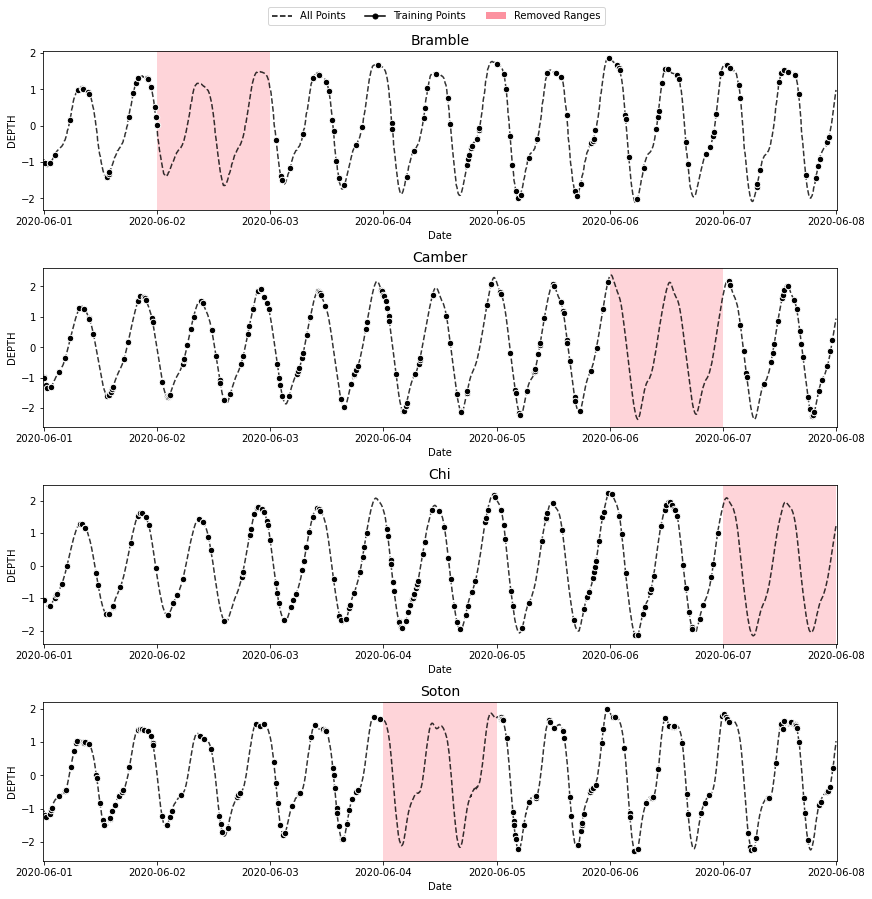

In [4]:
dataset.plot(transformed=True);

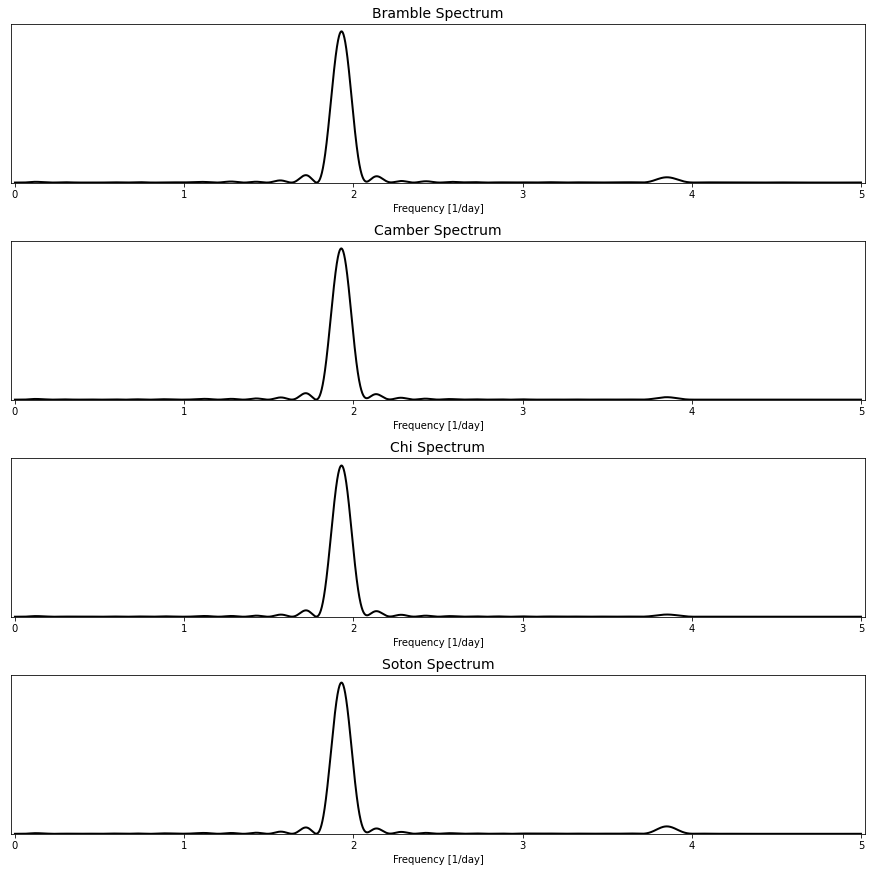

In [5]:
dataset.plot_spectrum(per='day', maxfreq=5, transformed=True);

In the spectral information of our dataset we can observe that all channels have a periodicity of (almost) twice a day. This is true as we know that the ebb and flow tides have a period of about 12 hours and 25 minutes, so that we have slightly less than two full periods a day. $1.93$ times to be exact.

We will now train the MOSM, CSM, SM-LMC, and CONV kernels on this data set and compare their prediction errors. Training using the Adam optimizer with a relatively high learning rate has proven to give good results.

In [6]:
method = 'Adam'
lr = 0.1
iters = 500

In [7]:
mosm = mogptk.MOSM(dataset, Q=2)
mosm.init_parameters(method='LS')
mosm.train(method=method, lr=lr, iters=iters, verbose=True)
mosm.predict();
mosm.print_parameters()


Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 4
‣ Mixtures: 2
‣ Training points: 643
‣ Parameters: 48
‣ Initial NLL: 0.384

Optimization finished in 1.84 minutes
‣ Function evaluations: 500
‣ Final NLL: -1.163


Name,Range,Value
Mixture[0].MOSM.noise,"[1e-08,∞)",[0.00065171 0.00115957 0.00073076 0.00102472]
Mixture[0].MOSM.magnitude,"[1e-08,∞)",[3.53379322 3.65889226 3.56252999 3.93913136]
Mixture[0].MOSM.mean,"[1e-08,∞)",[[0.02168097] [0.01870767] [0.01904504] [0.02271941]]
Mixture[0].MOSM.variance,"[1e-08,∞)",[[0.00232695] [0.00170108] [0.00193919] [0.00236907]]
Mixture[0].MOSM.delay,"(-∞,∞)",[[-0.53098817] [-0.42930169] [ 2.34540785] [-1.19728273]]
Mixture[0].MOSM.phase,"(-∞,∞)",[ 0.05154304 -0.02639842 -0.13523961 0.07703572]
Mixture[1].MOSM.noise,"[1e-08,∞)",[0.00065171 0.00115957 0.00073076 0.00102472]
Mixture[1].MOSM.magnitude,"[1e-08,∞)",[0.35753734 0.36748379 0.07367049 0.46640172]
Mixture[1].MOSM.mean,"[1e-08,∞)",[[0.04019655] [0.0406365 ] [0.68380084] [0.03988578]]
Mixture[1].MOSM.variance,"[1e-08,∞)",[[1.21911588e-04] [4.75949189e-05] [1.31978586e-04] [7.85848254e-05]]


In [8]:
csm = mogptk.CSM(dataset, Q=2)
csm.init_parameters(method='LS')
csm.train(method=method, lr=lr, iters=iters, verbose=True)
csm.predict();
csm.print_parameters()


Starting optimization using Adam
‣ Model: CSM
‣ Channels: 4
‣ Mixtures: 2
‣ Training points: 643
‣ Parameters: 28
‣ Initial NLL: 0.359

Optimization finished in 1.24 minutes
‣ Function evaluations: 500
‣ Final NLL: -0.214


Name,Range,Value
Mixture[0].CSM.noise,"[1e-08,∞)",[0.00156321 0.00206621 0.00158068 0.00164371]
Mixture[0].CSM.amplitude,"[1e-08,∞)",[[0.76551973] [1.05830259] [1.00407183] [0.82983842]]
Mixture[0].CSM.mean,"[1e-08,∞)",[0.01500155]
Mixture[0].CSM.variance,"[1e-08,∞)",[0.00071047]
Mixture[0].CSM.shift,"(-∞,∞)",[[-0.01095751] [-0.02140921] [ 0.02038861] [ 0.00742572]]
Mixture[1].CSM.noise,"[1e-08,∞)",[0.00156321 0.00206621 0.00158068 0.00164371]
Mixture[1].CSM.amplitude,"[1e-08,∞)",[[0.40638719] [0.15457781] [0.09508382] [0.71960426]]
Mixture[1].CSM.mean,"[1e-08,∞)",[0.03398779]
Mixture[1].CSM.variance,"[1e-08,∞)",[0.00039826]
Mixture[1].CSM.shift,"(-∞,∞)",[[ 0.00543811] [-0.06450874] [ 0.05459192] [ 0.00522951]]


In [9]:
sm_lmc = mogptk.SM_LMC(dataset, Q=2)
sm_lmc.init_parameters(method='LS')
sm_lmc.train(method=method, lr=lr, iters=iters, verbose=True)
sm_lmc.predict();
sm_lmc.print_parameters()


Starting optimization using Adam
‣ Model: SM-LMC
‣ Channels: 4
‣ Mixtures: 2
‣ Training points: 643
‣ Parameters: 16
‣ Initial NLL: 0.745

Optimization finished in 1.04 minutes
‣ Function evaluations: 500
‣ Final NLL: -0.736


Name,Range,Value
LMC.noise,"[1e-08,∞)",[0.001142 0.02050062 0.00126244 0.00141624]
LMC[0].SM.weight,fixed,[1.]
LMC[0].SM.mean,"[1e-08,∞)",[0.00278141]
LMC[0].SM.variance,"[1e-08,∞)",[9.07240456e-05]
LMC[1].SM.weight,fixed,[1.]
LMC[1].SM.mean,"[1e-08,∞)",[0.02055937]
LMC[1].SM.variance,"[1e-08,∞)",[0.0002343]
LMC.weight,"[1e-08,∞)",[[[1.18626223] [0.31548194]] [[1.38753603] [0.2507812 ]] [[1.37447102] [0.15291781]] [[1.2344729 ] [0.42326512]]]
noise,fixed,0.0


In [10]:
conv = mogptk.CONV(dataset, Q=2)
conv.init_parameters(method='SM', sm_init='LS')
conv.train(method=method, lr=lr, iters=iters, verbose=True)
conv.predict();
conv.print_parameters()


Starting optimization using Adam
‣ Model: CONV
‣ Channels: 4
‣ Mixtures: 2
‣ Training points: 643
‣ Parameters: 26
‣ Initial NLL: 1.200

Optimization finished in 1.69 minutes
‣ Function evaluations: 500
‣ Final NLL: -0.533


Name,Range,Value
Mixture[0].CONV.noise,"[1e-08,∞)",[0.00061393 0.0063918 0.00057931 0.00047832]
Mixture[0].CONV.weight,"[1e-08,∞)",[0.15205192 0.25120652 0.44266263 0.05895836]
Mixture[0].CONV.variance,"[0.0,∞)",[[ 5.58757748] [ 0.04823845] [10.08114422] [ 0.18157138]]
Mixture[0].CONV.base_variance,"[1e-08,∞)",[13.306566]
Mixture[1].CONV.noise,"[1e-08,∞)",[0.00061393 0.0063918 0.00057931 0.00047832]
Mixture[1].CONV.weight,"[1e-08,∞)",[0.81489676 0.93014905 0.83405549 0.87969017]
Mixture[1].CONV.variance,"[0.0,∞)",[[3.31079783] [5.6204834 ] [0.87999237] [2.20505667]]
Mixture[1].CONV.base_variance,"[1e-08,∞)",[39.45511009]
noise,fixed,0.0


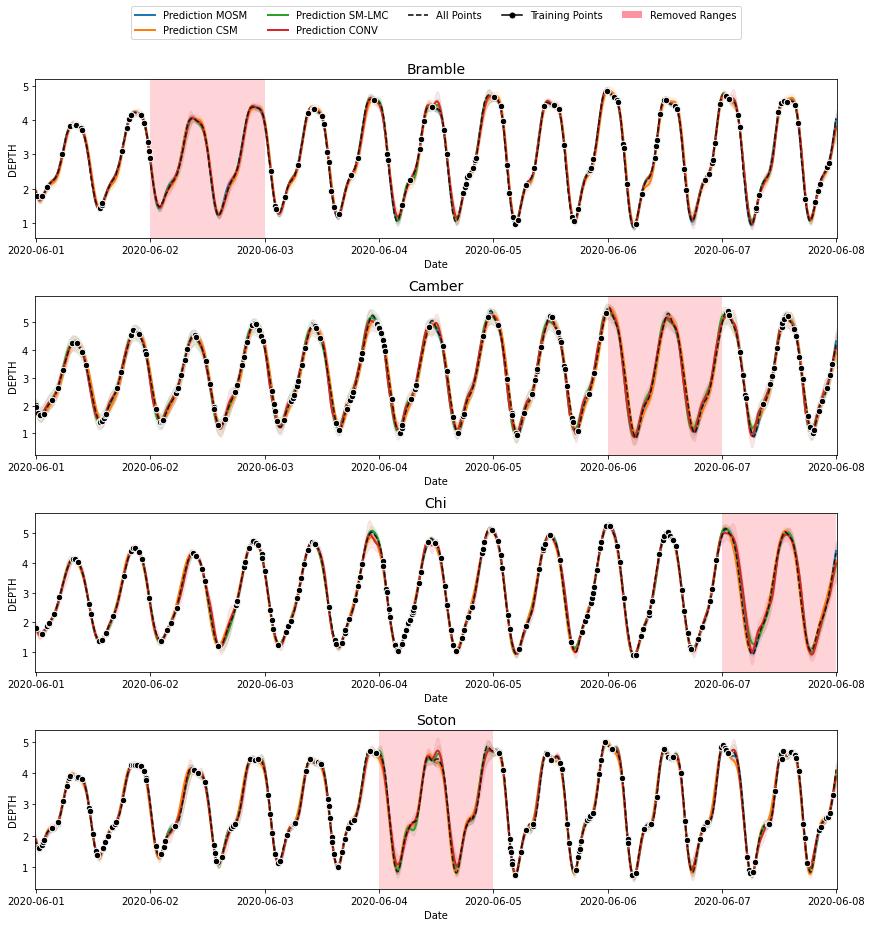

In [11]:
dataset.plot();

Above we can see that the models fit the data fairly well. For a quantitative analysis, below we calculate the prediction error using the MAE, RMSE, and MAPE metrics. It can be observed that in this case the MOSM model fits well to the data set.

In [12]:
mogptk.prediction_error(dataset, disp=True)

,MAE,RMSE,MAPE
Name,,,
MOSM,0.036820,0.047285,1.539956
CSM,0.088288,0.109224,3.471631
SM-LMC,0.070407,0.109136,3.072871
CONV,0.066614,0.106069,2.839187
